# Применение линейных моделей для определения токсичности комментария

## Градиента функции потерь (по параметру $w$) для задачи бинарной логистической регрессии.

$$L(a(x), y) = \log(1 + \exp(-y\langle w, x\rangle)), \quad y \in \{-1, 1\}$$




$$\frac{\partial}{\partial w_i} \log(1 + \exp(-y_i w^T X_i)) = \frac{\partial \exp (-y_i w^T X_i)}{1 + \exp (-y_i w^T X_i)} = \frac{\exp (-y_i w^T X_i) \partial (-y w^T X_i)}{1 + \exp (-y_i w^T X_i)} = \frac{\exp (-y_i w^T X_i)(-y_i X_{ij})}{1 + \exp (-y_i w^T X_i)}$$


$$\Rightarrow$$

$$\nabla L(a(x), y)_{w_j} = \frac{1}{N} \sum\limits_{i=1}^N \frac{-y_i*X_{ij}}{1 + \exp (y_i*w^T*X_i)}$$

## Предобработка данных

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import time
from collections import defaultdict
from scipy.sparse import load_npz

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download("stopwords")
noise = stopwords.words('english')
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix, save_npz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss, MultinomialLoss
from modules.utils import get_numeric_grad, compute_balanced_accuracy

[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Загрузка даннных
Эксперименты этого задания будем проводить на датасете, содержащим комментарии из раздела обсуждений английской Википедии, который был преобразован для решения задачи бинарной классификации: является ли данный комментарий токсичным или нет. Подробнее об исходных данных [здесь](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Требуемый датасет можно найти по следующей [ссылке](https://drive.google.com/file/d/1FLTAFR29Koi4YDkLUdVQWNabnBQCTFbn/view). 


Данные в датасете записаны в формате `csv`. Для базовой части экспериментов используем в качестве целевой переменной столбец `is_toxic`.

In [231]:
df = pd.read_csv("train.csv")
df

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


### 2. Предобработка текста
Произведем предварительную обработку текста. Приведем все тексты к нижнему регистру. Заменим в тексте все символы, не являющиеся буквами и цифрами, на пробелы. Применим алгоритм лемматизации к коллекции. Удалим из текста стоп-слова .



In [233]:
tw = TweetTokenizer()
det = TreebankWordDetokenizer()

def tokenize_filter_detokenize(s):
    tokenized_example = tw.tokenize(s.replace("\n", " "))
    filtered_example = []
    for word in tokenized_example:
        if word.isalnum():
            if not (word in noise):
                filtered_example.append(word.lower())
    return det.detokenize(filtered_example)    

In [234]:
for i in tqdm(range(len(df))):
    df['comment_text'][i] = tokenize_filter_detokenize(df["comment_text"][i])

  0%|          | 0/159571 [00:00<?, ?it/s]/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 159571/159571 [06:14<00:00, 425.59it/s]


In [235]:
df.to_csv("clean_df.csv")

### 3. Train/val
Разделим данные на обучение и валидацию. Для валидации выберем $30\%$ случайных объектов из датасета.

In [61]:
df = pd.read_csv('clean_df.csv')
X = df["comment_text"]
y = df['is_toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### 4. Tf-idf
Преобразуем текст в разреженную матрицу `scipy.sparse.csr_matrix`, где значение $x$ в позиции $(i, j)$ сответствует tf-idf характеристке $j$-го слова в $i$-ом документе.


In [96]:
X_train = X_train.fillna(value = " ")
X_test = X_test.fillna(value = " ")

In [97]:
tfidf = TfidfVectorizer(min_df=10)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [239]:
X_train_tfidf = csr_matrix(hstack([csr_matrix(np.ones((X_train_tfidf.shape[0], 1))), X_train_tfidf]))
X_test_tfidf = csr_matrix(hstack([csr_matrix(np.ones((X_test_tfidf.shape[0], 1))), X_test_tfidf]))

In [240]:
y_train = (y_train*2)-1
y_test = (y_test*2)-1

In [242]:
save_npz('X_train_tfidf.npz', X_train_tfidf)
save_npz('X_test_tfidf.npz', X_test_tfidf)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)


## Эксперименты 

### 1. Исследование параметров градиентного спуска 

В спецификации предлагается использовать следующую формулу для выбора темпа обучения $\eta_k$:


$$\eta_k  = \frac{\alpha}{k^{\beta}}, \quad \text{где $\alpha$, $\beta$ - заданные константы}, \; \text{$k$ - номер итерации}$$


Исследуем поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`

Исследование поведения подразумевает анализ следующих зависимостей на обучающей и валидационной
выборках:

- зависимость значения функции потерь от реального времени работы метода
- зависимость значения функции потерь от эпохи метода
- значение метрики качества после обучения метода

В качестве метрики качества здесь и далее будем использовать сбалансированную точность (balanced accuracy), реализацию, совместимую с множеством меток $\{−1, 1\}$, можно найти в модуле `utils`.



In [98]:
y_train = np.load("y_train.npy")
X_train_tfidf = load_npz("X_train_tfidf.npz")

In [99]:
X_train_exp, X_val, y_train_exp, y_val = train_test_split(X_train_tfidf, y_train, test_size = 0.3)
y_train_exp = np.squeeze(np.array([y_train_exp]))
y_val = np.squeeze(np.array([y_val]))

values = [0.1, 0.5, 1, 2]
loss_function = BinaryLogisticLoss(l2_coef=0.1)
combinations = list(itertools.product(values, values))

In [100]:
dict_epoch_loss_train = defaultdict()
dict_epoch_loss_val = defaultdict()
dict_time_loss_train = defaultdict()
dict_time_loss_val = defaultdict()

for alpha, beta in tqdm(combinations):
    
    model = LinearModel(loss_function = loss_function, step_alpha = alpha, step_beta = beta)
    history = model.fit(X_train_exp, y_train_exp, trace = True, X_val = X_val, y_val = y_val)

    dict_epoch_loss_train[(alpha,beta)] = history["func"]
    dict_epoch_loss_val[(alpha,beta)] = history["func_val"]
    
    train_loss = history['func'][-1]
    val_loss = history['func_val'][-1]
    
    total_time = np.sum(history['time'])

    dict_time_loss_train[total_time] = (train_loss, (alpha,beta))
    dict_time_loss_val[total_time] = (val_loss, (alpha,beta))


100%|██████████| 16/16 [07:13<00:00, 27.08s/it]


In [11]:
dict_metric_train = defaultdict()
dict_metric_val = defaultdict()
for alpha, beta in tqdm(combinations):
    
    model = LinearModel(loss_function = loss_function, step_alpha = alpha, step_beta = beta)
    model.fit(X_train_exp, y_train_exp)
    threshold = model.get_optimal_threshold(X_val, y_val)
    
    y_pred_train = model.predict(X_train_exp, threshold = threshold)
    y_pred_val = model.predict(X_val, threshold = threshold)

    dict_metric_train[(alpha,beta)] = compute_balanced_accuracy(y_train_exp, y_pred_train)
    dict_metric_val[(alpha,beta)] = compute_balanced_accuracy(y_val, y_pred_val)  

100%|██████████| 16/16 [03:14<00:00, 12.16s/it]


#### Приведем график / таблицу с результатами ваших экспериментов

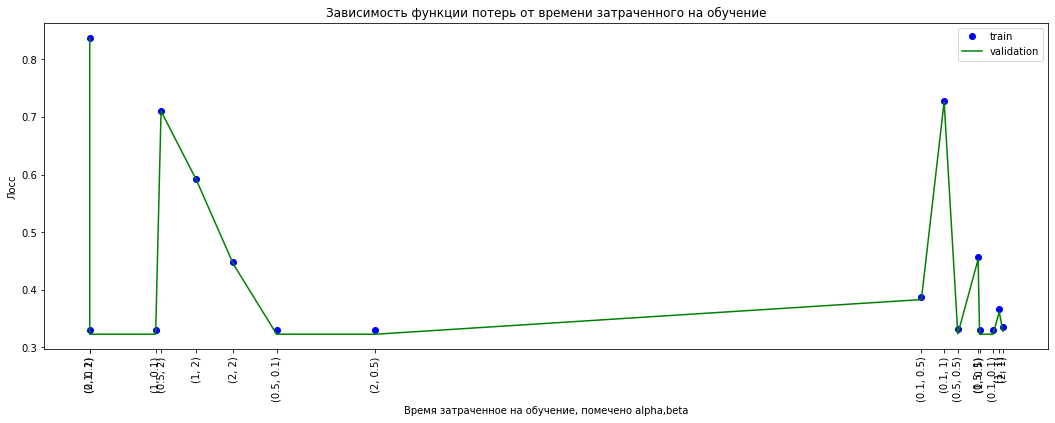

In [102]:
dict_time_loss_train = {k: v for k, v in sorted(dict_time_loss_train.items(), key=lambda item: item[0])}
secs = list(dict_time_loss_train.keys())
score = [s[0] for s in list(dict_time_loss_train.values())]
ab = [s[1] for s in list(dict_time_loss_train.values())]

dict_time_loss_val = {k: v for k, v in sorted(dict_time_loss_val.items(), key=lambda item: item[0])}
score_val = [s[0] for s in list(dict_time_loss_val.values())]

plt.figure(figsize=(18, 6))
plt.plot(secs, score, 'bo', label="train")
plt.plot(secs, score_val, label='validation', color='green')
plt.xticks(secs, ab, rotation='vertical')
plt.xlabel("Время затраченное на обучение, помечено alpha,beta")
plt.ylabel("Лосс")
plt.title("Зависимость функции потерь от времени затраченного на обучение")

plt.legend()
plt.show()



In [103]:
dict_time_loss_val

{1.3217031955718994: (0.8373602275113521, (0.1, 2)),
 1.322077989578247: (0.32297241718437825, (2, 0.1)),
 2.681605339050293: (0.3229727738780303, (1, 0.1)),
 2.7934627532958984: (0.7100526935242516, (0.5, 2)),
 3.5215752124786377: (0.5908994284839808, (1, 2)),
 4.287961483001709: (0.44431140137759806, (2, 2)),
 5.178187131881714: (0.3229735310569518, (0.5, 0.1)),
 7.217470407485962: (0.3229760789912513, (2, 0.5)),
 18.482271432876587: (0.3830949706649765, (0.1, 0.5)),
 18.951953887939453: (0.7265716026754874, (0.1, 1)),
 19.234243154525757: (0.3234271930944376, (0.5, 0.5)),
 19.653191089630127: (0.4528122131563531, (0.5, 1)),
 19.683897495269775: (0.3229865260727312, (1, 0.5)),
 19.960087537765503: (0.3229994001068753, (0.1, 0.1)),
 20.08997392654419: (0.36167627475201436, (1, 1)),
 20.162861347198486: (0.32846522190626976, (2, 1))}

(0.1, 0.1)


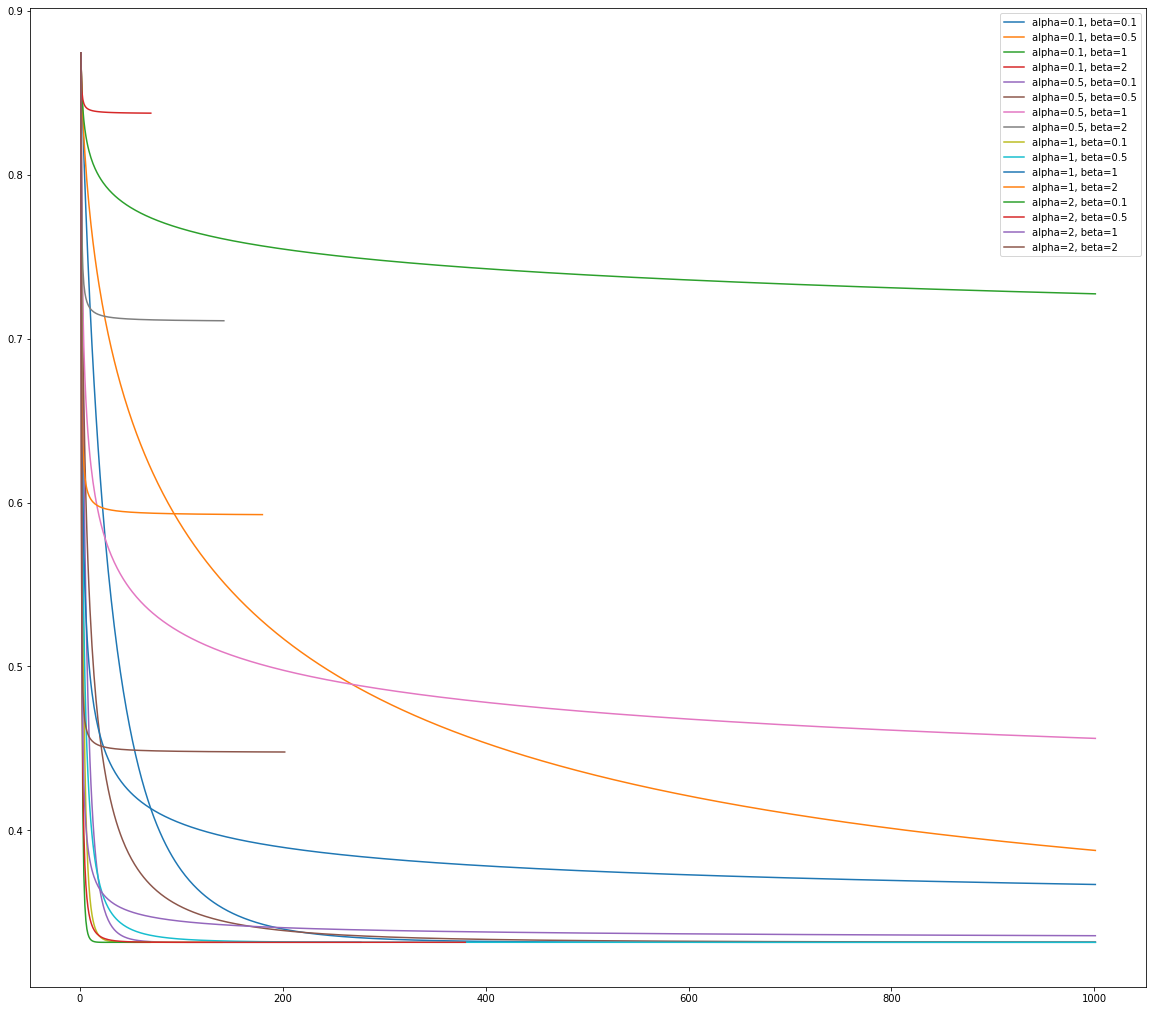

In [24]:
res_train = list(dict_epoch_loss_train.items())
res_val = list(dict_epoch_loss_val.items())
min_loss = 1


plt.figure(figsize=(20, 18))

for i in range(len(res_train)):
    vals_train = res_train[i][1]
    vals_val = res_val[i][1]

    N = np.arange(1,len(vals_train)+1)
    
    plt.plot(N, vals_val, label="alpha={}, beta={}".format(res_train[i][0][0], res_train[i][0][1]))
    #plt.xlabel("Эпоха")
    #plt.ylabel("Лосс")
    #plt.title("alpha={}, beta={}".format(res_train[i][0][0], res_train[i][0][1]))
    plt.legend()
   # plt.show()
    
    if vals_val[-1] < min_loss:
        min_loss = vals_val[-1]
        opt_alpha_beta = res_train[i][0]
print(opt_alpha_beta)

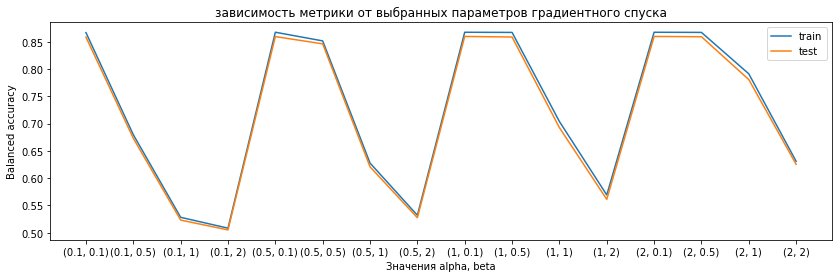

In [25]:
keys = list(dict_metric_train.keys())
res_train = list(dict_metric_train.values())
res_val = list(dict_metric_val.values())

plt.figure(figsize=(14,4))
plt.plot(np.arange(len(keys)), res_train, label="train")
plt.plot(np.arange(len(keys)), res_val, label='test')
plt.xticks(np.arange(len(keys)), keys)
plt.xlabel('Значения alpha, beta')
plt.ylabel("Balanced accuracy")
plt.title("зависимость метрики от выбранных параметров градиентного спуска")
plt.legend()
plt.show()

#### Ключевые моменты

1. Оптимальные `step_alpha` и `step_beta`.

Самыми оптимальными параметрами получились alpha = 2, beta = 0.1, это видно из лосса, к которому они приходят. Мы почти сразу попадаем в минимум, быстрее остальных и по времени он самый быстрый. При этих параметрах мы идем достаточно интесивно, так, что вначале можно совершать большие шаги и постепенно меньше. Тем более, что это самый быстрый результат, который имеет лосс сравнимый с другими оптимальными решениями, а также оптимальное качество на отложенной выборке.

2. Зависимости между параметрами `step_alpha`/`step_beta` и временем работы алгоритма/кол-ва эпох.

При больших параметрах beta мы заканчиваем раньше, потому что шаг становится совсем маленький с течением эпохи, и из времени обучения видно, что оно короче. 
При маленьких alpha видно, что мы почти во всех случаях будет проходить до максимума итераций, а при больших чаще останавливаться. Это хорошо согласуется с теорией, ведь мы замедляем шаг, а следовательно первые большие шаги привели нас в нужную область и осталось только постепенно прийти в нее за счет уменьшения шага от беты.
    

Время работы различается довольно сильно, быстрее сходится ГД с большими параметрами. медленне с маленьким шагом.

3. Пометка о том, почему метрика именно балансед акьюраси

Преимущество в том, что класса 1, то есть токсичных комментариев довольно мало, около 10%, так что если бы мы смотрели на обычный accuracy, то предсказав все классом -1 мы бы получили accuracy=0.9, в связи с дисбалансом классов. Поэтому необходимо пользоваться сбалансированным экьюраси

### 2. Исследование параметров стахастического градиентного спуска 
Исследуем поведение стохастического градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`
- размер подвыборки `batch_size`


Исследование поведения подразумевает анализ следующих зависимостей на обучающей и валидационной
выборках:

- зависимость значения функции потерь от реального времени работы метода
- зависимость значения функции потерь от эпохи метода
- значение метрики качества после обучения метода



Реализовывать выбор всего и сразу получается теперь очень громоздким и непонятным для визуализации, поэтому сначала мы проведем эксперименты над размером подвыборки, а затем с этим параметром аналогично прошлому пункту посмотрим на значения. Значения для альфы и беты и их комбинации мы уже имеем с прошлого пункта, ровно как и разбитие на трейн и валидацию, оставим их такими же для удобства сравнения. А еще я себе сюда скопировал часть прошлого текста, чтобы не бегать назад

In [44]:
batch_size = [256, 512, 1024, 8192, 16384, 32768]

In [45]:
dict_epoch_loss_train = defaultdict()
dict_epoch_loss_val = defaultdict()
dict_time_loss_train = defaultdict()
dict_time_loss_val = defaultdict()
dict_metric_train = defaultdict()
dict_metric_val = defaultdict()

for bs in tqdm(batch_size):
    
    model = LinearModel(loss_function = loss_function, batch_size = bs)
    history = model.fit(X_train_exp, y_train_exp, trace = True, X_val = X_val, y_val = y_val)

    dict_epoch_loss_train[bs] = history["func"]
    dict_epoch_loss_val[bs] = history["func_val"]
    
    train_loss = history['func'][-1]
    val_loss = history['func_val'][-1]
    
    total_time = np.sum(history['time'])

    dict_time_loss_train[total_time] = (train_loss, bs)
    dict_time_loss_val[total_time] = (val_loss, bs)
    
    threshold = model.get_optimal_threshold(X_val, y_val)
    
    y_pred_train = model.predict(X_train_exp, threshold = threshold)
    y_pred_val = model.predict(X_val, threshold = threshold)

    dict_metric_train[bs] = compute_balanced_accuracy(y_train_exp, y_pred_train)
    dict_metric_val[bs] = compute_balanced_accuracy(y_val, y_pred_val)  


100%|██████████| 6/6 [10:52<00:00, 108.67s/it]


#### Приведем график / таблицу с результатами ваших экспериментов

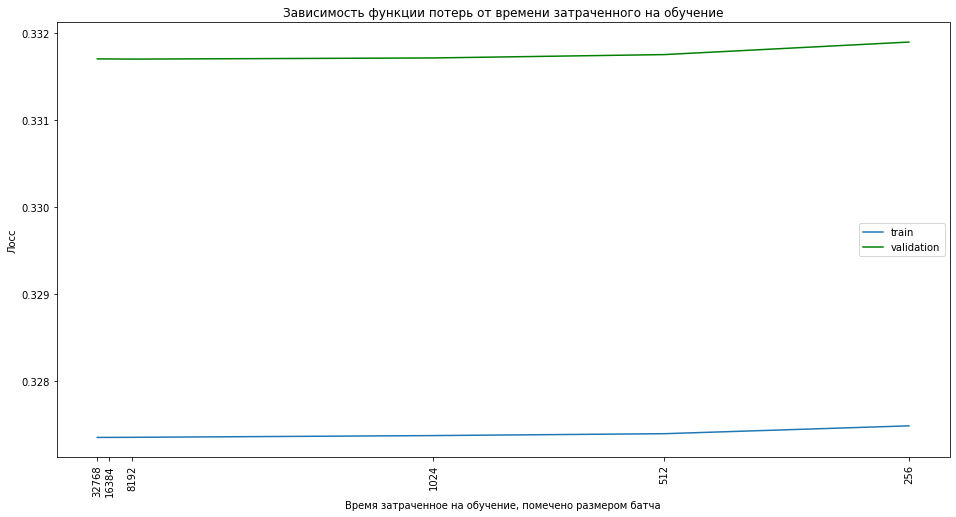

In [47]:
dict_time_loss_train = {k: v for k, v in sorted(dict_time_loss_train.items(), key=lambda item: item[0])}
secs = list(dict_time_loss_train.keys())
score = [s[0] for s in list(dict_time_loss_train.values())]
bs = [s[1] for s in list(dict_time_loss_train.values())]

dict_time_loss_val = {k: v for k, v in sorted(dict_time_loss_val.items(), key=lambda item: item[0])}
score_val = [s[0] for s in list(dict_time_loss_val.values())]

plt.figure(figsize=(16,8))
plt.plot(secs, score, label="train")
plt.plot(secs, score_val, label='validation', color='green')
plt.xticks(secs, bs, rotation='vertical')
plt.xlabel("Время затраченное на обучение, помечено размером батча")
plt.ylabel("Лосс")
plt.title("Зависимость функции потерь от времени затраченного на обучение")

plt.legend()
plt.show()

8192


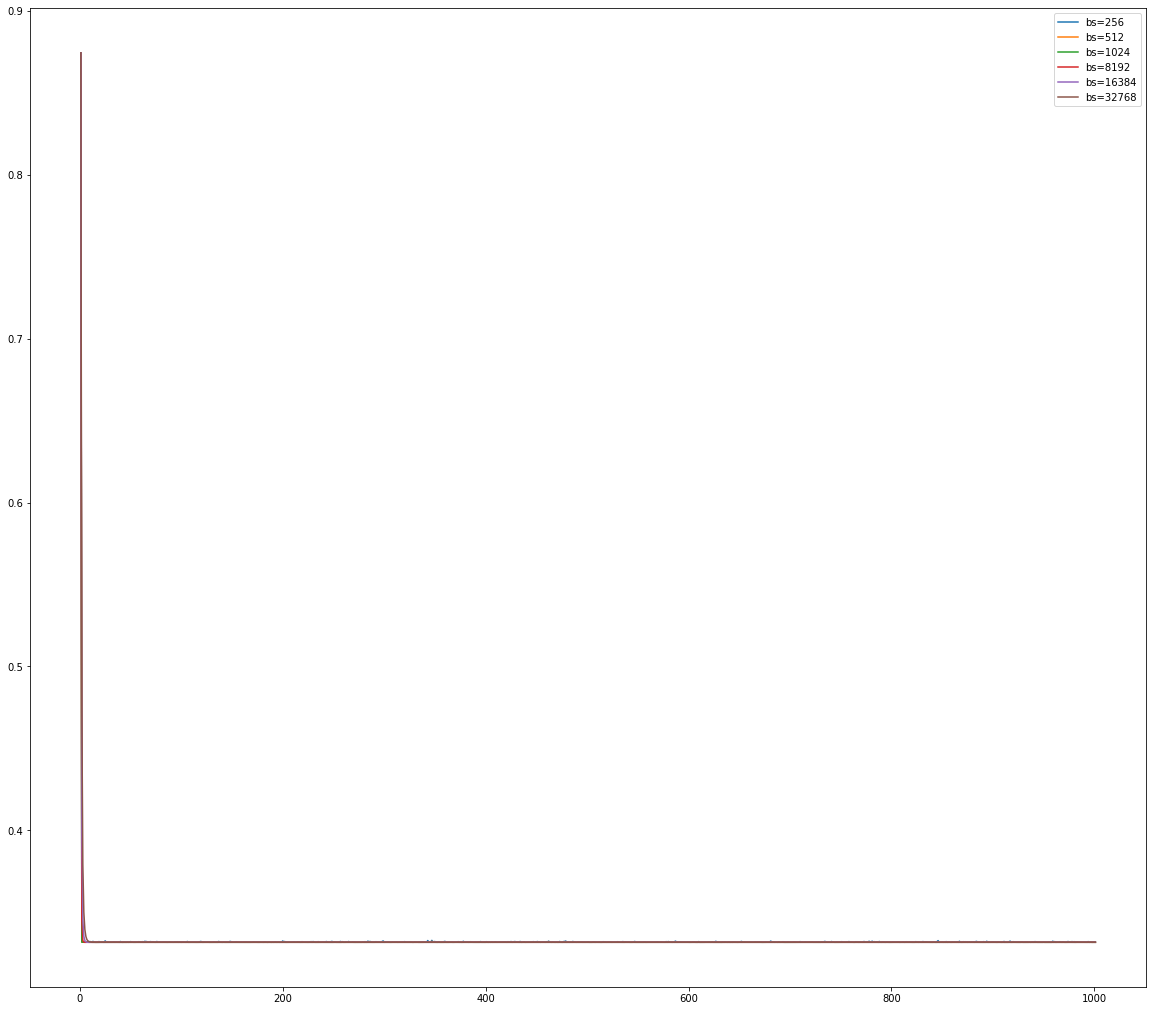

In [48]:
res_train = list(dict_epoch_loss_train.items())
res_val = list(dict_epoch_loss_val.items())
min_loss = 1

plt.figure(figsize=(20, 18))

for i in range(len(res_train)):
    vals_train = res_train[i][1]
    vals_val = res_val[i][1]

    N = np.arange(1,len(vals_train)+1)
    
    plt.plot(N, vals_val, label="bs={}".format(res_train[i][0]))
    #plt.xlabel("Эпоха")
    #plt.ylabel("Лосс")
    #plt.title("alpha={}, beta={}".format(res_train[i][0][0], res_train[i][0][1]))
    plt.legend()
   # plt.show()
    
    if vals_val[-1] < min_loss:
        min_loss = vals_val[-1]
        opt_alpha_beta = res_train[i][0]
print(opt_alpha_beta)

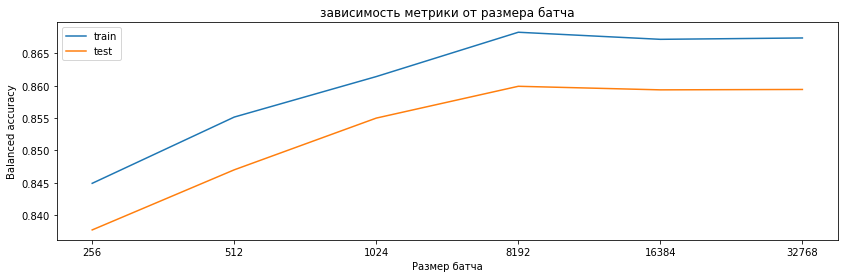

In [49]:
keys = list(dict_metric_train.keys())
res_train = list(dict_metric_train.values())
res_val = list(dict_metric_val.values())

plt.figure(figsize=(14,4))
plt.plot(np.arange(len(keys)), res_train, label="train")
plt.plot(np.arange(len(keys)), res_val, label='test')
plt.xticks(np.arange(len(keys)), keys)
plt.xlabel('Размер батча')
plt.ylabel("Balanced accuracy")
plt.title("зависимость метрики от размера батча")
plt.legend()
plt.show()

Теперь мы опрелились почти точно с размером батча, это будет 8192, результаты него по качеству лучшие, но 8192 лучше еще и самый быстрый. И теперь с этим размером проведем тесты альфы и беты.

In [50]:
bs = 8192

dict_epoch_loss_train = defaultdict()
dict_epoch_loss_val = defaultdict()
dict_time_loss_train = defaultdict()
dict_time_loss_val = defaultdict()
dict_metric_train = defaultdict()
dict_metric_val = defaultdict()

for alpha, beta in tqdm(combinations):
    
    model = LinearModel(loss_function = loss_function, batch_size = bs,
                        step_alpha = alpha, step_beta = beta)
    
    history = model.fit(X_train_exp, y_train_exp, trace = True, X_val = X_val, y_val = y_val)

    dict_epoch_loss_train[(alpha, beta)] = history["func"]
    dict_epoch_loss_val[(alpha, beta)] = history["func_val"]
    
    train_loss = history['func'][-1]
    val_loss = history['func_val'][-1]
    
    total_time = np.sum(history['time'])

    dict_time_loss_train[total_time] = (train_loss, (alpha, beta))
    dict_time_loss_val[total_time] = (val_loss, (alpha, beta))
    
    threshold = model.get_optimal_threshold(X_val, y_val)
    
    y_pred_train = model.predict(X_train_exp, threshold = threshold)
    y_pred_val = model.predict(X_val, threshold = threshold)

    dict_metric_train[(alpha, beta)] = compute_balanced_accuracy(y_train_exp, y_pred_train)
    dict_metric_val[(alpha, beta)] = compute_balanced_accuracy(y_val, y_pred_val)  
  

100%|██████████| 16/16 [12:20<00:00, 46.27s/it]


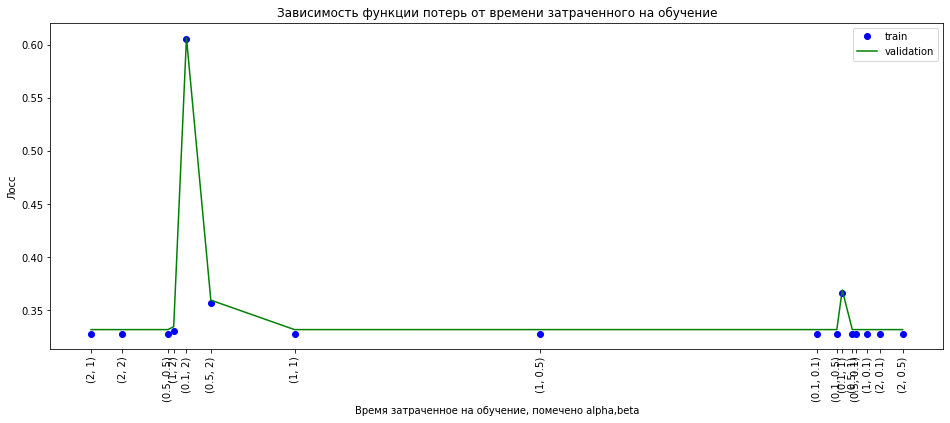

In [52]:
dict_time_loss_train = {k: v for k, v in sorted(dict_time_loss_train.items(), key=lambda item: item[0])}
secs = list(dict_time_loss_train.keys())
score = [s[0] for s in list(dict_time_loss_train.values())]
ab = [s[1] for s in list(dict_time_loss_train.values())]

dict_time_loss_val = {k: v for k, v in sorted(dict_time_loss_val.items(), key=lambda item: item[0])}
score_val = [s[0] for s in list(dict_time_loss_val.values())]

plt.figure(figsize=(16, 6))
plt.plot(secs, score, 'bo', label="train")
plt.plot(secs, score_val, label='validation', color='green')
plt.xticks(secs, ab, rotation='vertical')
plt.xlabel("Время затраченное на обучение, помечено alpha,beta")
plt.ylabel("Лосс")
plt.title("Зависимость функции потерь от времени затраченного на обучение")

plt.legend()
plt.show()

(0.5, 1)


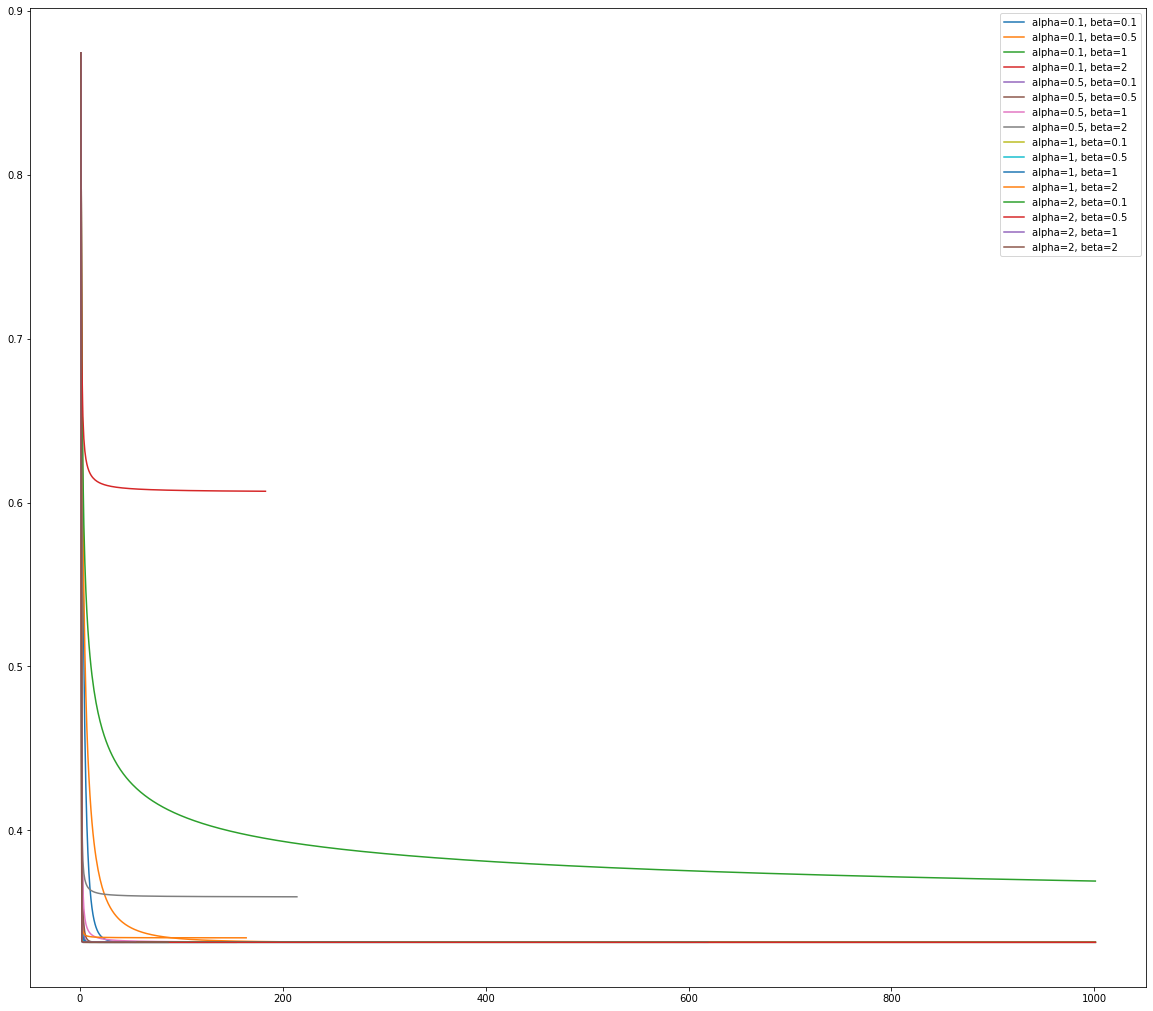

In [53]:
res_train = list(dict_epoch_loss_train.items())
res_val = list(dict_epoch_loss_val.items())
min_loss = 1


plt.figure(figsize=(20, 18))

for i in range(len(res_train)):
    vals_train = res_train[i][1]
    vals_val = res_val[i][1]

    N = np.arange(1,len(vals_train)+1)
    
    plt.plot(N, vals_val, label="alpha={}, beta={}".format(res_train[i][0][0], res_train[i][0][1]))
    #plt.xlabel("Эпоха")
    #plt.ylabel("Лосс")
    #plt.title("alpha={}, beta={}".format(res_train[i][0][0], res_train[i][0][1]))
    plt.legend()
   # plt.show()
    
    if vals_val[-1] < min_loss:
        min_loss = vals_val[-1]
        opt_alpha_beta = res_train[i][0]
print(opt_alpha_beta)

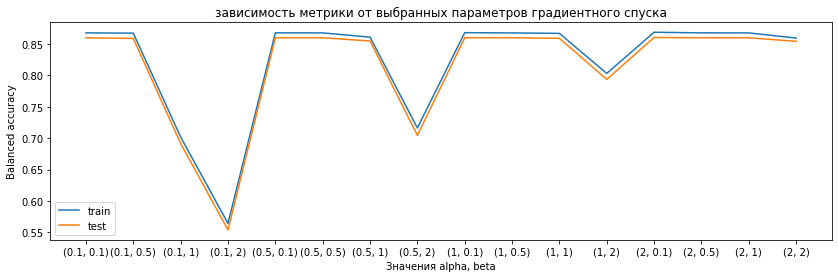

In [54]:
keys = list(dict_metric_train.keys())
res_train = list(dict_metric_train.values())
res_val = list(dict_metric_val.values())

plt.figure(figsize=(14,4))
plt.plot(np.arange(len(keys)), res_train, label="train")
plt.plot(np.arange(len(keys)), res_val, label='test')
plt.xticks(np.arange(len(keys)), keys)
plt.xlabel('Значения alpha, beta')
plt.ylabel("Balanced accuracy")
plt.title("зависимость метрики от выбранных параметров градиентного спуска")
plt.legend()
plt.show()

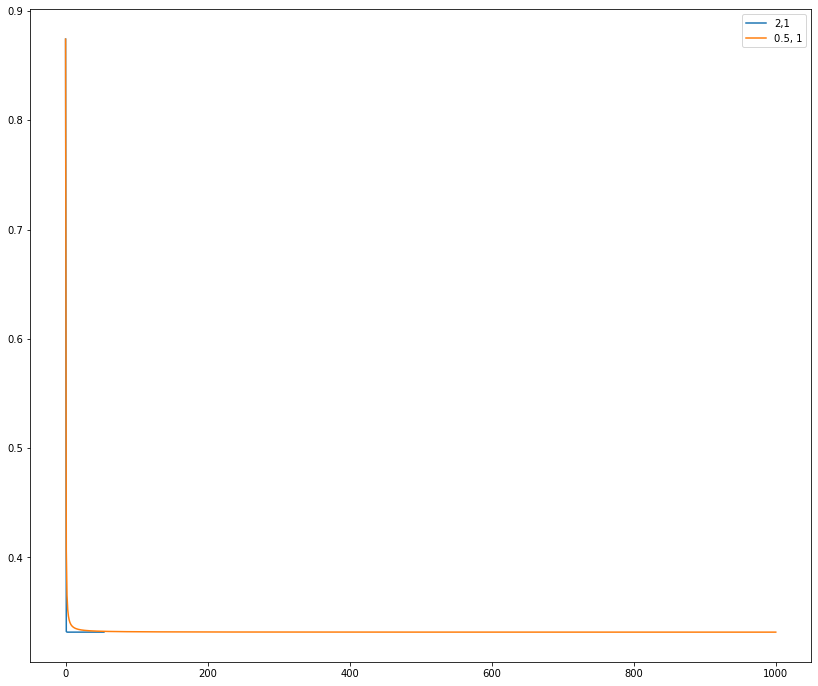

In [67]:
plt.figure(figsize=(14,12))
plt.plot(dict_epoch_loss_val[(2,1)], label='2,1')
plt.plot(dict_epoch_loss_val[(0.5,1)], label='0.5, 1')
plt.legend()

#### Ключевые моменты

1. Оптимальные `step_alpha`, `step_beta` и `batch_size`.

Батч сайз мы возьмем 8192, потому что на нем достигается лучший результат в кратчайшее время. В качестве альфы мы возьем 2, в качестве беты 1. При таких параметрах метод работает быстрее всего и имеет лосс сравнимый с другими параметрами, высокое качество и сходится очень очень быстро. Это видно из последнего графика, на котором показаны эти параметры и другой с наивысшим лоссом.

2. Зависимости между параметрами `step_alpha`/`step_beta`/`batch_size` и временем работы алгоритма/кол-ва эпох.

Батч сайз видно, сходится примерно к одному значению, однако с разной скоростью. Связано это скорее всего с тем, что матричные операции выполняются намного быстрее и перебрать все батчи занимает большое время. 
При больших бета мы тратим меньшее количество эпох на обучение, но сходимся хуже, подозреваю, что это связано с особенностью структуры данных и тем, что алгоритм не успевает достаточно далеко шагнуть. Если же бета маленькая, то будем долго скакать вокруг, пока не упремся в максимум итераций.
Когда альфа меньше беты значительно мы еще и получаем плохое качество по тем же причинам.
    

### 3. Сравнение двух методов 
Сравним поведение двух методов между собой, и ответим на следующие вопросы

1. Выбор дальнейшего алгоритма

Для дальнейших экспериментов будем использовать стохастический градиентный спуск, потому что он быстрее сходится и качество при правильных параметрах выше.


2. Разница между парами оптимальных параметров `step_alpha` и `step_beta` в двух алгоритмах.

Разница заключается в том, что как правило нам нужно делать меньше шагов в сгд. То есть данные параметры влиют после того как мы прошлись по всей выборке и нам чаще выгоднее делать бету больше, чтобы раньше заканчивать. В обычном ГД это так не работает, те же параметры 2,1 показывают очень большое время.

### 4. Регуляризация
Подберем по отложенной выборке коэффициент $l2$-регуляризации модели. 

Приведем график с результатами ваших экспериментов. Обоснуйте свой выбор.

In [68]:
bs = 8192
alpha = 2
beta = 1

In [69]:
dict_epoch_loss_train = defaultdict()
dict_epoch_loss_val = defaultdict()
dict_time_loss_train = defaultdict()
dict_time_loss_val = defaultdict()
dict_metric_train = defaultdict()
dict_metric_val = defaultdict()
l2_vals = [0.01, 0.1, 0.5, 1, 2, 3]


for l2 in tqdm(l2_vals):
    
    loss_function = BinaryLogisticLoss(l2_coef=l2)

    
    model = LinearModel(loss_function = loss_function, batch_size = bs,
                        step_alpha = alpha, step_beta = beta)
    
    history = model.fit(X_train_exp, y_train_exp, trace = True, X_val = X_val, y_val = y_val)

    dict_epoch_loss_train[l2] = history["func"]
    dict_epoch_loss_val[l2] = history["func_val"]
    
    train_loss = history['func'][-1]
    val_loss = history['func_val'][-1]
    
    total_time = np.sum(history['time'])

    dict_time_loss_train[total_time] = (train_loss, l2)
    dict_time_loss_val[total_time] = (val_loss, l2)
    
    threshold = model.get_optimal_threshold(X_val, y_val)
    
    y_pred_train = model.predict(X_train_exp, threshold = threshold)
    y_pred_val = model.predict(X_val, threshold = threshold)

    dict_metric_train[l2] = compute_balanced_accuracy(y_train_exp, y_pred_train)
    dict_metric_val[l2] = compute_balanced_accuracy(y_val, y_pred_val)  

100%|██████████| 6/6 [04:51<00:00, 48.59s/it]


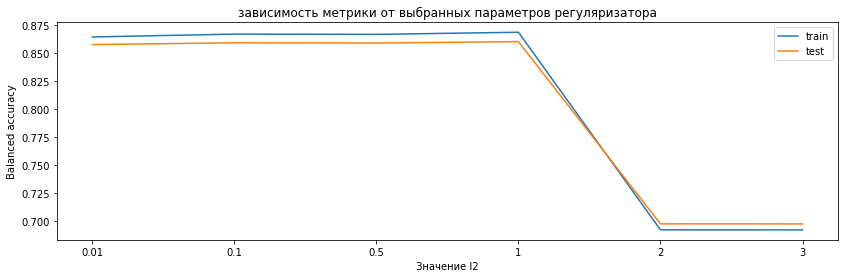

In [77]:
keys = list(dict_metric_train.keys())
res_train = list(dict_metric_train.values())
res_val = list(dict_metric_val.values())

plt.figure(figsize=(14,4))
plt.plot(np.arange(len(keys)), res_train, label="train")
plt.plot(np.arange(len(keys)), res_val, label='test')
plt.xticks(np.arange(len(keys)), keys)
plt.xlabel('Значение l2')
plt.ylabel("Balanced accuracy")
plt.title("зависимость метрики от выбранных параметров регуляризатора")
plt.legend()
plt.show()

In [93]:
dict_metric_val

defaultdict(None,
            {0.01: 0.8577838536467691,
             0.1: 0.859383058411526,
             0.5: 0.8591442521516826,
             1: 0.860418954215745,
             2: 0.6973092530667022,
             3: 0.6972593429049931})

Из графиков видно, что самым высоким качеством на валидационной выборке обладает коэффцииент 1, его и возьмем

### 5. Измерение качества и интерпретация результатов 
Выберем лучший алгоритм для тестовой выборки. Обратим внимание, что необходимо использовать порог бинаризации, выбранный на отложенной выборке.

In [94]:
bs = 8192
alpha = 2
beta = 1
l2 = 1

y_test = np.load("y_test.npy")
X_test_tfidf = load_npz("X_test_tfidf.npz")

In [95]:
loss_function = BinaryLogisticLoss(l2_coef=l2)
model = LinearModel(loss_function = loss_function, batch_size = bs, step_alpha = alpha, step_beta = beta)
model.fit(X_train_exp, y_train_exp)
threshold = model.get_optimal_threshold(X_val, y_val)


In [96]:
#val accuracy
y_pred = model.predict(X_val, threshold = threshold)
compute_balanced_accuracy(y_val, y_pred)

0.859383058411526

In [97]:
#test accuracy
y_pred = model.predict(X_test_tfidf, threshold = threshold)
compute_balanced_accuracy(y_test, y_pred)

0.8593231660199583

# Проанализируем ошибки алгоритма. 

Очень мало объектов 1 класса, то есть токсичных, на них тем не менее неплохая доля правильных предсказаний. Много ошибочно помеченных токсичными высказываний, которые таковыми не являются. Видно, что в объектах какие то сложные предложения, возможно часть слов могут трактоваться двусмысленно или иногда применяться как сарказм


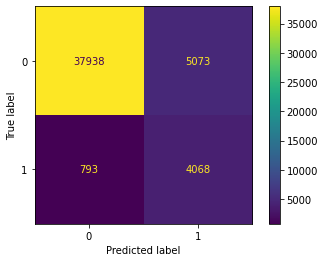

In [57]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()